In [2]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm

import datetime
import pickle
import importlib
import json
import time
import glob
from skimage.metrics import structural_similarity as ssim

from gaussian_fit_eve import gaussian_fit_eve
from data.eve_const import  wavelength_list_eve



## orginal 

before fitting

In [8]:
with open('./data/original_data.pkl', 'wb') as file:
    pickle.dump(original_df, file)

In [2]:
with open('./data/original_data.pkl', 'rb') as file:
    original_df = pickle.load(file)
original_df

,time,irradiance
0,2010-04-30 00:00:00,"[2.6092563e-05, 0.00013120413, 0.00046210643, ..."
1,2010-04-30 00:00:10,"[2.4313835e-05, 0.00012673343, 0.00045906374, ..."
2,2010-04-30 00:00:20,"[2.5151077e-05, 0.00012693906, 0.00045360095, ..."
3,2010-04-30 00:00:30,"[2.5799252e-05, 0.00012680102, 0.0004512957, 0..."
4,2010-04-30 00:00:40,"[2.7351613e-05, 0.00012936983, 0.0004534847, 0..."
...,...,...
12996715,2014-12-31 22:59:19,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
12996716,2014-12-31 22:59:29,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
12996717,2014-12-31 22:59:39,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
12996718,2014-12-31 22:59:49,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [6]:
# original_df  irradiance column is array, I want to replace negative in the array with np.nan
def replace_negative_one(x):
    # x[x<0]=np.nan
    x=np.where(x<0, np.nan, x)
    return x

original_df['irradiance'] = original_df['irradiance'].apply(replace_negative_one)

In [6]:
irradiance=np.array(original_df['irradiance'].tolist())

In [26]:
# Define the number of rows with np.nan to add (3000000 rows in this example)
num_nan_rows = 3000000

# Create an array of np.nan with the desired shape (num_nan_rows, 12)
nan_array = np.full((num_nan_rows, 12), np.nan)

# Concatenate the np.nan array with the original irradiance_array
concatenated_array = np.concatenate((irradiance, nan_array), axis=0)

In [23]:
irradiance.shape

(12996720, 12)

In [27]:
concatenated_array.shape

(15996720, 12)

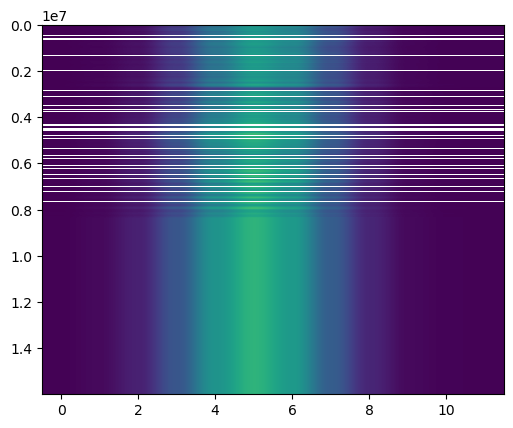

In [28]:
plt.imshow(concatenated_array,aspect=6e-7,)

### 自动插值
疑问？？

[Text(0, 0.0, '2010-04-30'),
 Text(0, 3249179.75, '2011-05-19'),
 Text(0, 6498359.5, '2012-06-03'),
 Text(0, 9747539.25, '2013-06-15'),
 Text(0, 12996719.0, '2014-12-31')]

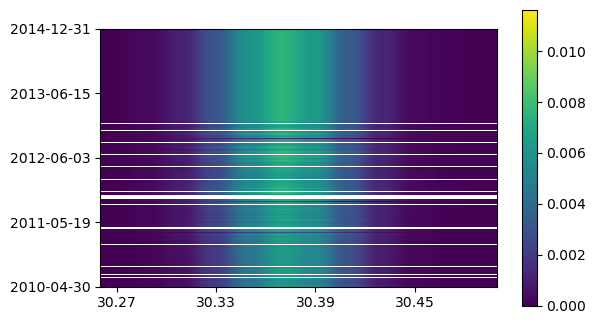

In [57]:
fig,ax=plt.subplots()
sc=ax.imshow(irradiance,aspect=6e-7,origin='lower'
            # , interpolation='none'
            )
fig.colorbar(sc,shrink=0.8)

# set x tick label using wavelength_list_eve
ax.set_xticks(np.arange(0,len(wavelength_list_eve),3))
ax.set_xticklabels(wavelength_list_eve[::3])

# set y tick label using date in time, set 5 ticks in total
ax.set_yticks(np.linspace(0,len(original_df)-1,5))
ax.set_yticklabels([original_df['time'][i].date() for i in np.linspace(0,len(original_df)-1,5).astype(int)])


## 10s

In [6]:
time_list = original_df.index.tolist()

In [3]:
original_df.iloc[0]['irradiance']

array([2.6092563e-05, 1.3120413e-04, 4.6210643e-04, 2.0390972e-03,
       4.6766386e-03, 6.5146396e-03, 5.6786640e-03, 3.1078281e-03,
       9.0871193e-04, 1.9184785e-04, 7.4447729e-05, 5.0256080e-05],
      dtype=float32)

### fit check

In [3]:
mean_list=[]
stddev_list=[]
amp_list=[]
pcov_list=[]
time_list=[]

i=0
for key in list(original_df.index)[:]:
    popt,pcov=gaussian_fit_eve(wavelength_list_eve,original_df.iloc[key]['irradiance'])
    amplitude, mean, stddev=popt
    time=original_df.iloc[key]['time']


    amp_list.append(amplitude)
    mean_list.append(mean)
    stddev_list.append(stddev)

    pcov_list.append(pcov)
    time_list.append(time)

    # if not np.isnan(cen):
    # print(key,cen)


    i=i+1
    if(i%86400==0):
        print(key,mean)


fit_df={    'time':time_list,
           'amplitude':amp_list,
           'mean':mean_list,
           'stddev':stddev_list,
           'pcov':pcov_list,
           
            }
            
fit_df=pd.DataFrame(fit_df)

with open('./data/fit_df.pkl', 'wb') as file:
    pickle.dump(fit_df, file)

86399 30.374267882286016
172799 30.37266078342511
259199 30.372712101560154
345599 30.374629693870528
431999 30.37409532480058
518399 30.373941752961947
604799 30.374138239983765
691199 30.374229746684755
777599 [nan]
863999 30.373659503022235
950399 30.374064867988753
1036799 30.374128923236746
1123199 30.373900351690565


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1209599 30.374505201824817
1295999 30.374870697253012
1382399 30.374192828227056
1468799 30.373938255145767
1555199 30.37454533507014
1641599 30.37352446065396
1727999 30.373810265948652
1814399 30.373733983870682
1900799 30.373655085067607
1987199 30.373991148063407
2073599 30.37365576835379
2159999 30.373622680362903
2246399 30.37403964278921
2332799 30.37383691583676
2419199 30.373346592292762
2505599 30.37413988251278
2591999 30.372976006597728
2678399 30.373973335955554
2764799 30.37463489549162
2851199 30.372869028645912
2937599 30.372973179146232
3023999 30.373050457011846
3110399 30.37276418674677
3196799 30.37327288805736
3283199 30.37326526545869
3369599 30.372701395146358
3455999 30.37322515174669
3542399 30.372168784748943
3628799 30.372399974810854
3715199 30.37259251614372
3801599 30.37249549740967
3887999 30.37225045757602
3974399 30.372951117487055
4060799 30.37251281116414
4147199 30.37273385469854
4233599 30.37322616331378
4319999 30.372925224788997
4406399 30.3729167

In [3]:
with open('./data/fit_df.pkl', 'rb') as file:
    fit_df=pickle.load(file)

In [50]:
fit_df

,time,amplitude,mean,stddev,pcov
0,2010-04-30 00:00:00,0.006621,30.374182,0.028687,"[[1.909934104783326e-09, 9.230200868174452e-14..."
1,2010-04-30 00:00:10,0.006623,30.374068,0.028704,"[[2.044234117378633e-09, 9.873151283360399e-14..."
2,2010-04-30 00:00:20,0.006581,30.374196,0.028695,"[[1.990928537734905e-09, 9.676613666554314e-14..."
3,2010-04-30 00:00:30,0.006522,30.374199,0.028807,"[[2.2657636938190113e-09, 1.1100608871630828e-..."
4,2010-04-30 00:00:40,0.006493,30.374291,0.028811,"[[2.02770143185137e-09, 9.9755436572809e-14, -..."
...,...,...,...,...,...
12996715,2014-12-31 22:59:19,NaN,NaN,NaN,"[[nan, nan, nan], [nan, nan, nan], [nan, nan, ..."
12996716,2014-12-31 22:59:29,NaN,NaN,NaN,"[[nan, nan, nan], [nan, nan, nan], [nan, nan, ..."
12996717,2014-12-31 22:59:39,NaN,NaN,NaN,"[[nan, nan, nan], [nan, nan, nan], [nan, nan, ..."
12996718,2014-12-31 22:59:49,NaN,NaN,NaN,"[[nan, nan, nan], [nan, nan, nan], [nan, nan, ..."


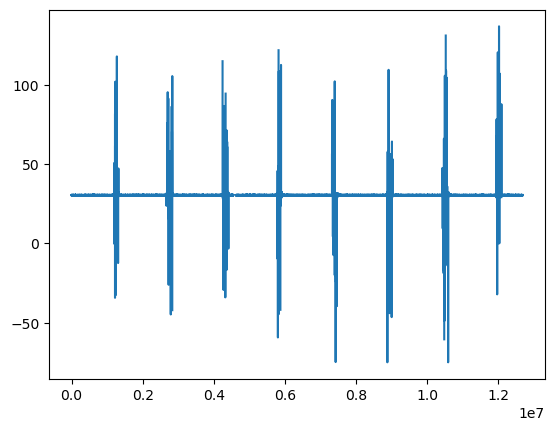

In [4]:
plt.plot(fit_df['mean'])

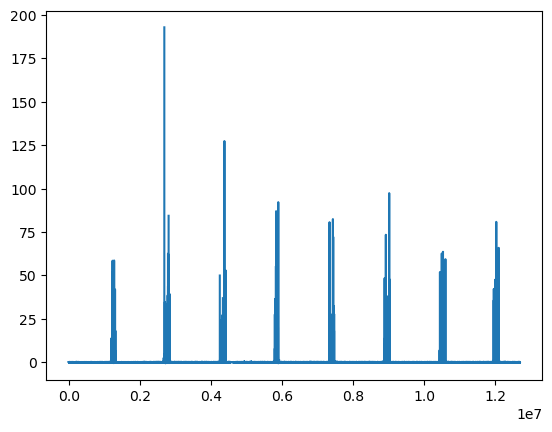

In [8]:
plt.plot(fit_df['stddev'])

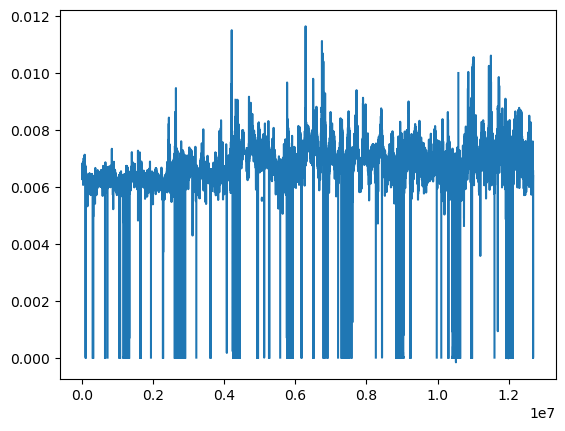

In [9]:
plt.plot(fit_df['amplitude'])

## day

In [57]:
fit_df.set_index('time',inplace=True)

In [67]:
def f(x):
    y=np.size(x)-np.sum(np.isnan(x))
    return y

stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
available_data=fit_df['amplitude'].resample('D').agg(f)

In [68]:
columns_to_agg = ['amplitude', 'mean', 'stddev']
daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

# Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
# fwhm=2.3*stddev
daily_df = pd.DataFrame()
daily_df['median_of_mean'] = daily_median['mean']
daily_df['median_of_stddev'] = daily_median['stddev']
daily_df['median_of_amplitude'] = daily_median['amplitude']

daily_df['stddev_of_mean']=stddev_of_mean
daily_df['stddev_of_fwhm']=stddev_of_stddev
daily_df['stddev_of_amplitude']=stddev_of_amplitude

daily_df['available_data']=available_data

# Print the new DataFrame
daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_fwhm,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,30.374138,0.028824,0.006518,0.000175,0.028135,0.000058,8570
2010-05-01,30.374133,0.028945,0.006556,0.000199,0.024264,0.000052,8579
2010-05-02,30.374000,-0.029009,0.006503,0.000210,0.028173,0.000048,8579
2010-05-03,30.373922,-0.029029,0.006513,0.000206,0.026981,0.000049,8640
2010-05-04,30.373876,0.028986,0.006656,0.000195,0.017351,0.000059,8578
...,...,...,...,...,...,...,...
2014-12-27,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-29,NaN,NaN,NaN,NaN,NaN,NaN,0


In [69]:
with open('./data/daily_df.pkl', 'wb') as file:
    pickle.dump(daily_df, file)

In [70]:
with open('./data/daily_df.pkl', 'rb') as file:
    daily_df=pickle.load(file)

In [72]:
amplitude=daily_df['median_of_amplitude'].values
mean=daily_df['median_of_mean'].values
stddev=daily_df['median_of_stddev'].values

def get_abs_diff_matrix(a):
    a=np.array(a)
    b=np.abs(a-a[:,np.newaxis])
    return b
    
amplitude_diff_matrix=get_abs_diff_matrix(amplitude)
mean_diff_matrix=get_abs_diff_matrix(mean)
stddev_diff_matrix=get_abs_diff_matrix(stddev)

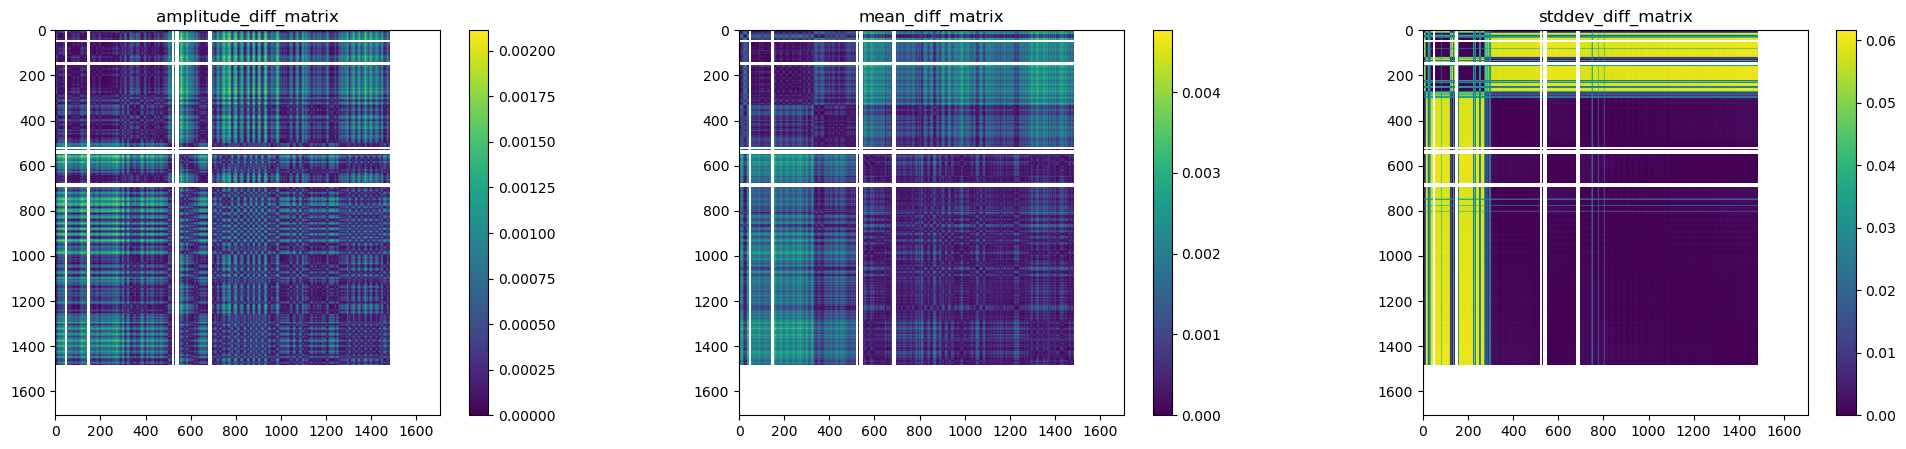

In [75]:
#imshow amplitude_diff_matrix, mean_diff_matrix, stddev_diff_matrix
fig,ax=plt.subplots(1,3,figsize=(25,5))
sc=ax[0].imshow(amplitude_diff_matrix)
ax[0].set_title('amplitude_diff_matrix')
fig.colorbar(sc,ax=ax[0])

sc=ax[1].imshow(mean_diff_matrix)
ax[1].set_title('mean_diff_matrix')
fig.colorbar(sc,ax=ax[1])

sc=ax[2].imshow(stddev_diff_matrix)
ax[2].set_title('stddev_diff_matrix')
fig.colorbar(sc,ax=ax[2])

plt.savefig('./data/fit_diff_matrix.png')

In [1]:
np.full((3, 1), np.nan)

NameError: name 'np' is not defined